In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import *
from scipy.constants import c, pi
from scipy.integrate import quad
import scipy.special as sc

In [2]:
def a_plus(n, angle):
    N = np.round((pi + angle) / (2 * pi * n))
    return 2 * np.cos((2 * n * pi * N - angle) / 2) ** 2


def a_minus(n, angle):
    N = np.round((-pi + angle) / (2 * pi * n))
    return 2 * cos((2 * n * pi * N - angle) / 2) ** 2


def cot(x):
    return 1 / tan(x)


def F(x):
    x = atleast_1d(x)
    neg = x < 0

    x[neg] *= 1

    S, C = sc.fresnel(np.sqrt(2 / pi) * np.sqrt(x))
    res = (
        2j
        * sqrt(x)
        * exp(1j * x)
        * (
            (1 / 2 + 1j / 2)
            * sqrt(pi / 2)
            * ((-1 + 1j) * x * C + (1 + 1j) * sqrt(x**2) * S - 1j * x)
        )
        / x
    )

    res[neg] = np.conj(res[neg])
    return res


def D_s_h(n, k, beta_0, phi, phi_p, Li, Lrn, Lro):

    factor = -exp(-1j * pi / 4) / (2 * n * sqrt(2 * pi * k) * sin(beta_0))

    D1 = (
        factor
        * cot((pi + (phi - phi_p)) / (2 * n))
        * F(k * Li * a_plus(n, phi - phi_p))
    )
    D2 = (
        factor
        * cot((pi - (phi - phi_p)) / (2 * n))
        * F(k * Li * a_minus(n, phi - phi_p))
    )
    D3 = (
        factor
        * cot((pi + (phi + phi_p)) / (2 * n))
        * F(k * Lrn * a_plus(n, phi + phi_p))
    )
    D4 = (
        factor
        * cot((pi - (phi + phi_p)) / (2 * n))
        * F(k * Lro * a_minus(n, phi + phi_p))
    )

    return D1 + D2 - D3 - D4, D1 + D2 + D3 + D4


def Et(theta, r, f=1e9):

    l = c / f
    k = 2 * pi / l
    a = 3 * l

    E = zeros_like(theta, dtype=complex64)  # theta direction

    ejkr_r = exp(-1j * k * r) / r
    n = 2

    los = (theta > 0) * (theta < pi / 2)

    E[los] += sin(theta[los]) * ejkr_r

    beta_0 = pi / 2

    # Q
    p = a / sin(theta)
    phi_p = 0
    phi = pi / 2 + theta
    Li = Lro = Lrn = a
    _, D_h = D_s_h(n, k, beta_0, phi, phi_p, Li, Lrn, Lro)
    EdQ = (
        0.5 * D_h * ejkr_r * exp(-1j * k * a * (1 - sin(theta))) / sqrt(a * sin(theta))
    )

    # P

    phi = (pi / 2 - theta) * los + (5 * pi / 2 - theta) * (1 - los)
    _, D_h = D_s_h(n, k, beta_0, phi, phi_p, Li, Lrn, Lro)
    EdP = (
        -1j
        * 0.5
        * D_h
        * ejkr_r
        * exp(-1j * k * a * (1 + sin(theta)))
        / np.sqrt(a * sin(theta))
    )

    return E + EdP + EdQ

Text(0, 0.5, '$\\angle F(x)$')

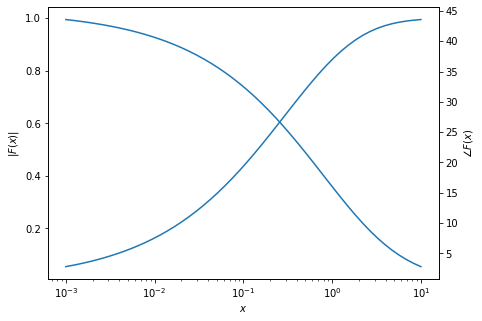

In [3]:
x = np.logspace(-3, 1)
y = F(x)
fig, ax1 = plt.subplots(figsize=(7, 5))
ax1.semilogx(x, abs(y))
ax1.set_xlabel(r"$x$")
ax1.set_ylabel(r"$|F(x)|$")
ax2 = ax1.twinx()
ax2.semilogx(x, np.rad2deg(np.angle(y)))
ax2.set_ylabel(r"$\angle F(x)$")

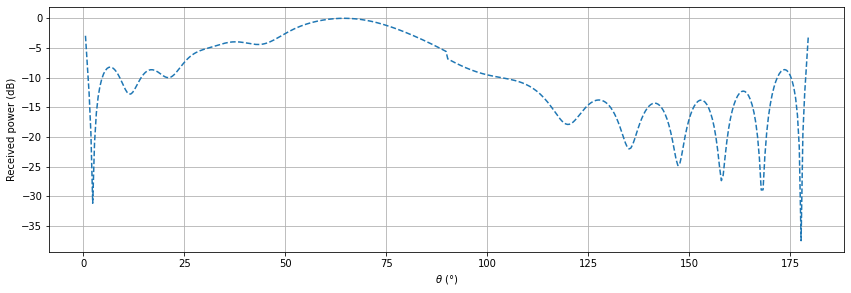

In [14]:
theta = np.linspace(0.01, pi - 0.01, 400)
r = 100

E = Et(theta, r)
P = 20 * np.log10(abs(E))
P = P - np.max(P)
plt.figure(figsize=(28.5/2, 9/2))
plt.plot(np.rad2deg(theta), P, "--")
plt.xlabel(r"$\theta$ (°)")
plt.ylabel(r"Received power (dB)")
plt.grid("on")

In [5]:
"""
def Et(theta, r, f=1e9, alpha=45):

    l = c / f
    k = 2 * pi / l
    a = 2.5 * l

    E = zeros(2, dtype=complex64)

    ejkr_r = exp(-1j * k * r) / r
    n = (2 * pi - deg2rad(alpha)) / pi

    los = (theta > 0) * (theta < pi / 2)

    if los:
        E[0] += sin(theta) * ejkr_r

    E_at_D = array([0, 0, -1]) * exp(-1j * k * a) / a

    beta_0 = pi / 2

    P = array([r * sin(theta), 0, r * cos(theta)])
    D = array([a, 0.0, 0.0])

    s_p = array([1.0, 0.0, 0.0])
    e = array([0.0, 1.0, 0.0])
    n0 = array([-cos(alpha / 2), 0, sin(alpha / 2)])
    t = cross(n0, e)
    s = P - D
    s_p /= np.linalg.norm(s_p)
    s_t = s - dot(s, e) * e
    s_t /= np.linalg.norm(s_t)
    s_t_p = s_p - dot(s_p, e) * e
    s_t_p /= np.linalg.norm(s_t_p)

    phi_p_dir = -cross(e, s_p)
    phi_p_dir /= np.linalg.norm(phi_p_dir)
    beta_0_p_dir = cross(phi_p_dir, s_p)

    # Diffraction
    phi_p = pi - (pi - arccos(dot(-s_t_p, t))) * sign(dot(-s_t_p, n0))
    phi = pi - (pi - arccos(dot(s_t, t))) * sign(dot(s_t, n0))
    Li = Lro = Lrn = np.linalg.norm(s)
    D_s, D_h = D_s_h(n, k, beta_0, phi, phi_p, Li, Lrn, Lro)
    EdP = zeros(2, dtype=complex64)

    EdP[0] = -D_s * dot(E_at_D, beta_0_p_dir)
    EdP[1] = -D_h * dot(E_at_D, phi_p_dir)

    s = np.linalg.norm(s)
    rho = a
    factor = np.sqrt(rho / (s * (s + rho))) * np.exp(-1j * k * s)

    return E + EdP *factor
""";
#

In [6]:
"""
n = 200

theta = np.linspace(0.01, pi - 0.01, n)
r = 100

plt.figure(figsize=(10, 7))

for alpha in [25, 45, 90]:

    E = np.zeros((n, 2), dtype=complex64)

    for i in range(n):
        E[i, :] = Et(theta[i], r, alpha=alpha)

# for t in theta:


# E = Et(theta, r)
    plt.plot(np.rad2deg(theta), 20 * np.log10(np.linalg.norm(E, axis=1)), label=f"{alpha}°")
    
plt.xlabel(r"$\theta$ (°)")
plt.ylabel(r"Received power (dB)")
plt.legend()
plt.grid("on")
""";
#